# Problem Statement

Money laundering remains a significant global issue, driving the need for improved transaction monitoring methods. Current anti-money laundering (AML) procedures are inefficient, and access to data is difficult/restricted by legal and privacy issues. Moreover, existing data often lacks diversity and true labels. This study introduces a novel AML transaction generator, creating the SAML-D dataset with enhanced features and typologies, aiming to aid researchers in evaluating their models and developing more advanced monitoring methods.

The dataset incorporates 12 features and 28 typologies (split between 11 normal and 17 suspicious). These were selected based on existing datasets, the academic literature, and interviews with AML specialists. The dataset comprises 9,504,852 transactions, of which 0.1039% are suspicious. It also includes 15 graphical network structures to represent the transaction flow within these typologies. The structures, while sometimes shared among typologies, vary significantly in parameters to increase complexities and challenge detection efforts. More details about these typologies are available in the paper above. The dataset is an updated version compared to the paper.

`Features of the SAML-D dataset`:

• Time and Date: Essential for tracking transaction chronology.

• Sender and Receiver Account Details: Helps uncover behavioural patterns and complex banking connections.

• Amount: Indicates transaction values to identify suspicious activities.

• Payment Type: Includes various methods like credit card, debit card, cash, ACH transfers, cross-border, and cheque.

• Sender and Receiver Bank Location: Pinpoints high-risk regions including Mexico, Turkey, Morocco, and the UAE.

• Payment and Receiver Currency: Align with location features, adding complexity when mismatched.

• 'Is Suspicious' Feature: Binary indicator differentiating normal from suspicious transactions.

• Type: Classifies typologies, offering deeper insights.

In [6]:
# Importing Libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [8]:
raw_df = pd.read_csv("/content/SAML-D.csv") # Load the Dataset

raw_df.shape

(9504852, 12)

In [9]:
df = raw_df.sample(n=100000, random_state=1)

df.shape

(100000, 12)

In [10]:
# Exploratory Data Analysis

df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
9232719,02:08:46,2023-08-14,4248061080,9527052910,13480.74,Mexican Peso,UK pounds,UK,UK,Debit card,0,Normal_Plus_Mutual
7996180,19:48:23,2023-07-02,9130896737,908371799,10480.05,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_Out
8575435,12:04:24,2023-07-22,1466348255,8545558838,26232.35,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Fan_Out
614744,17:08:02,2022-10-28,2181923623,6234034932,447.07,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out
4092093,22:44:17,2023-02-21,8596132461,3638213339,1005.62,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out


<Axes: xlabel='Is_laundering', ylabel='count'>

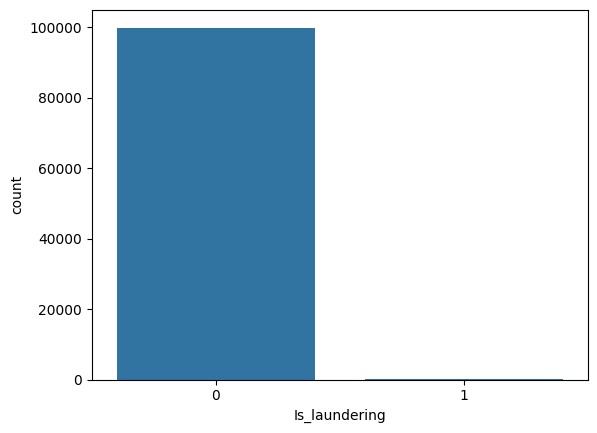

In [11]:
sns.countplot(data=df, x='Is_laundering')

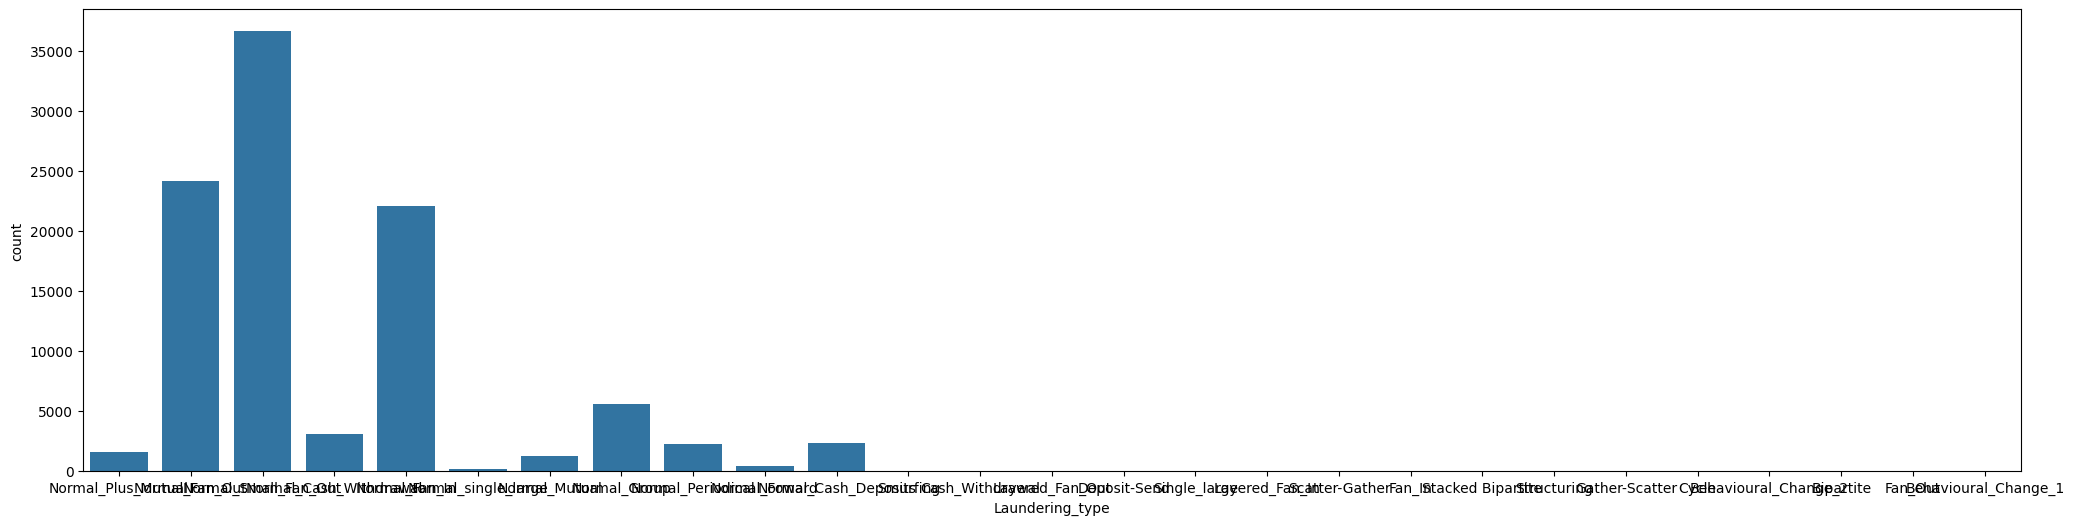

In [12]:
plt.figure(figsize=(25, 6))
sns.countplot(data=df, x='Laundering_type')
plt.show();

In [13]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 9232719 to 4931563
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Sender_account          100000 non-null  int64  
 3   Receiver_account        100000 non-null  int64  
 4   Amount                  100000 non-null  float64
 5   Payment_currency        100000 non-null  object 
 6   Received_currency       100000 non-null  object 
 7   Sender_bank_location    100000 non-null  object 
 8   Receiver_bank_location  100000 non-null  object 
 9   Payment_type            100000 non-null  object 
 10  Is_laundering           100000 non-null  int64  
 11  Laundering_type         100000 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 11.9+ MB


# Converting features into datetime features


In [15]:
# Converting date into datetime format

df['Date'] = pd.to_datetime(df['Date'])

# Extract month, day, and week

df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
df['Week'] = df['Date'].dt.isocalendar().week

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 9232719 to 4931563
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time                    100000 non-null  object        
 1   Date                    100000 non-null  datetime64[ns]
 2   Sender_account          100000 non-null  int64         
 3   Receiver_account        100000 non-null  int64         
 4   Amount                  100000 non-null  float64       
 5   Payment_currency        100000 non-null  object        
 6   Received_currency       100000 non-null  object        
 7   Sender_bank_location    100000 non-null  object        
 8   Receiver_bank_location  100000 non-null  object        
 9   Payment_type            100000 non-null  object        
 10  Is_laundering           100000 non-null  int64         
 11  Laundering_type         100000 non-null  object        
 12  Year                    1000

In [17]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'Year', 'Month', 'Day', 'Week'],
      dtype='object')

In [18]:
df.head(3)

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Year,Month,Day,Week
9232719,02:08:46,2023-08-14,4248061080,9527052910,13480.74,Mexican Peso,UK pounds,UK,UK,Debit card,0,Normal_Plus_Mutual,2023,8,14,33
7996180,19:48:23,2023-07-02,9130896737,908371799,10480.05,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_Out,2023,7,2,26
8575435,12:04:24,2023-07-22,1466348255,8545558838,26232.35,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Fan_Out,2023,7,22,29


<Axes: xlabel='Year', ylabel='count'>

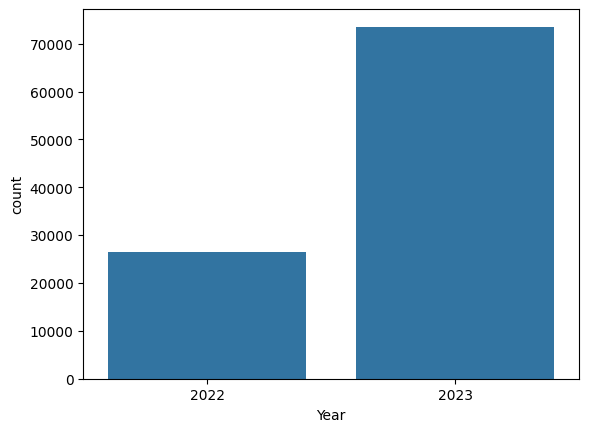

In [19]:
sns.countplot(data=df, x='Year')

In [20]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'Year', 'Month', 'Day', 'Week'],
      dtype='object')

In [21]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Cheque             21282
 Debit card         21214
 Credit card        21171
 ACH                20996
 Cross-border        9861
 Cash Withdrawal     3090
 Cash Deposit        2386
 Name: count, dtype: int64,
 Payment_type
 ACH                14
 Cash Deposit       16
 Cash Withdrawal    12
 Cheque              9
 Credit card        17
 Cross-border       23
 Debit card          9
 dtype: int64)

In [22]:
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     380012.980000
mean     17353.891942
min         50.100000
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     948662.900000
mean      8679.280692
min          9.150000
Name: Amount, dtype: float64


# Data Visualizations

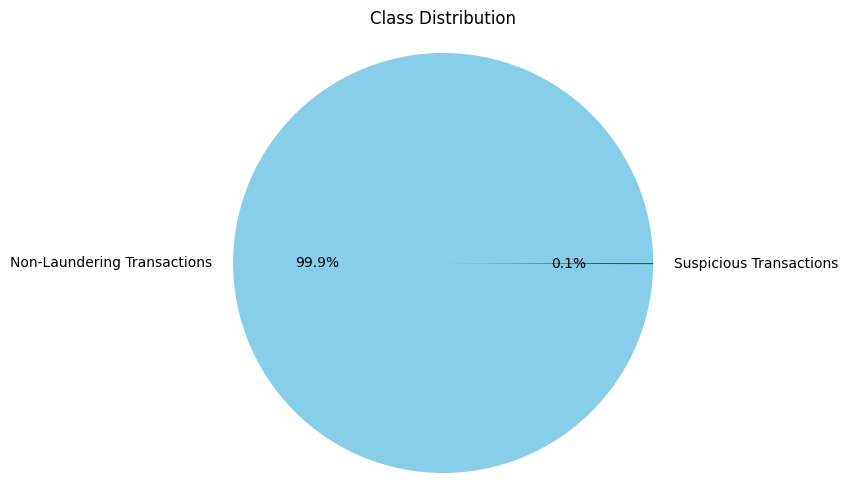

In [26]:
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'green'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show();

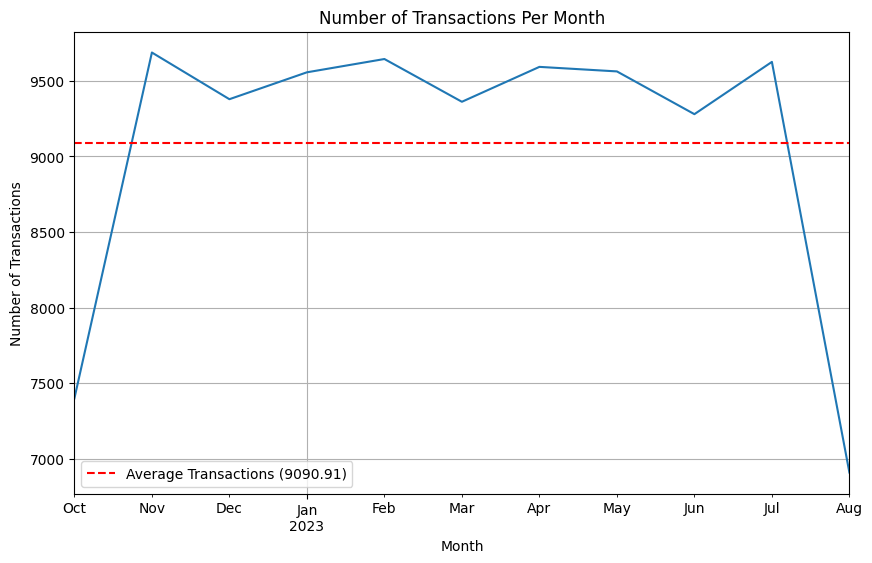

In [28]:
## Monthly Transactions

monthly_transactions = df.groupby(df['Date'].dt.to_period('M')).size()

average_monthly_transactions = monthly_transactions.mean()

plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.show();

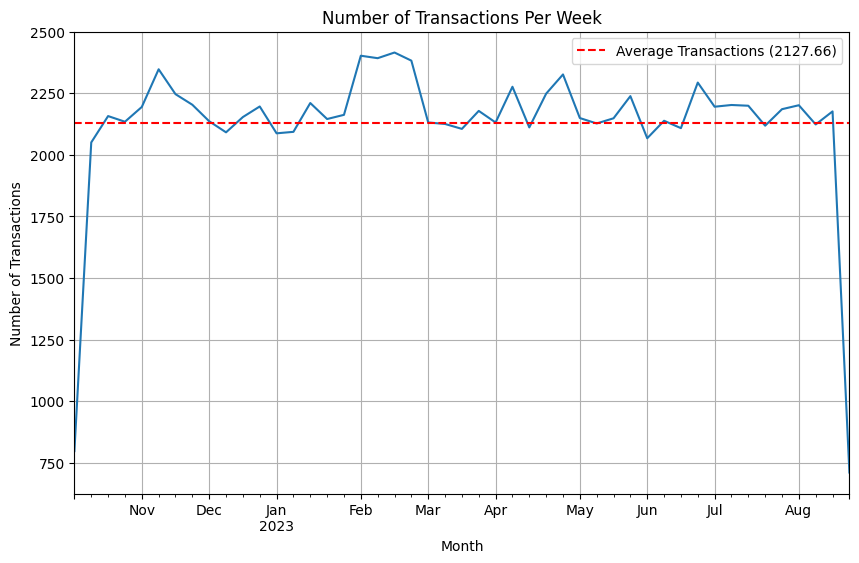

In [25]:
## Weekly Transactions

weekly_transactions = df.groupby(df['Date'].dt.to_period('W')).size()

average_weekly_transactions = weekly_transactions.mean()

plt.figure(figsize=(10, 6))
weekly_transactions.plot(kind='line')
plt.axhline(y=average_weekly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_weekly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Week')
plt.legend()
plt.grid(True)
plt.show();

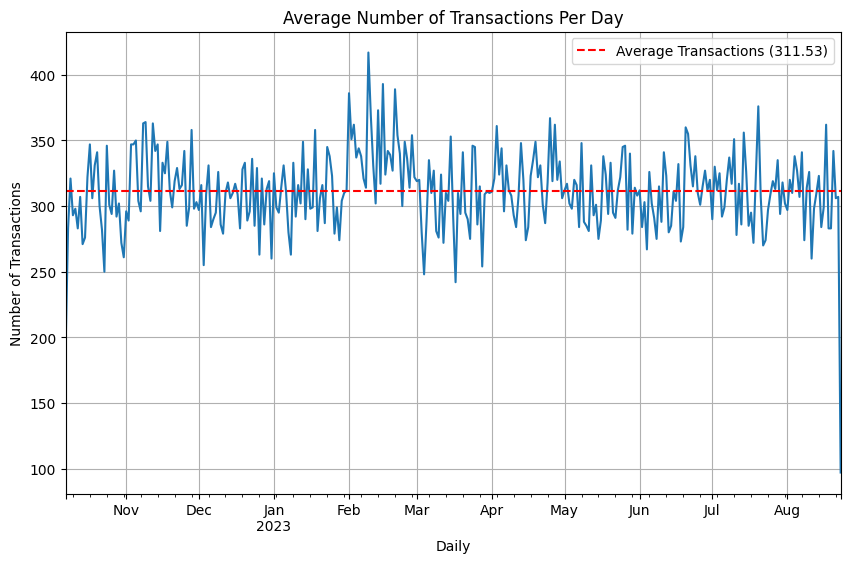

In [29]:
## Daily Transactions

daily_transactions = df.groupby(df['Date'].dt.to_period('D')).size()

average_daily_transactions = daily_transactions.mean()


plt.figure(figsize=(10, 6))
daily_transactions.plot(kind='line')
plt.axhline(y=average_daily_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_daily_transactions:.2f})')
plt.xlabel('Daily')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Day')
plt.legend()
plt.grid(True)
plt.show();

In [30]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'Year', 'Month', 'Day', 'Week'],
      dtype='object')

In [31]:
df['Is_laundering'].value_counts()

,count
Is_laundering,
0,99900
1,100


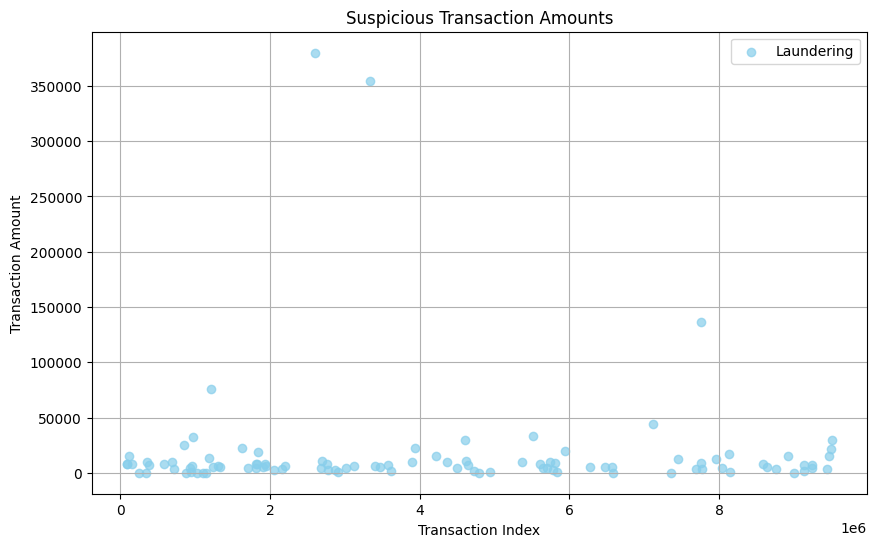

In [34]:
# Separate the data

laundering_data = df[df['Is_laundering'] == 1]
non_laundering_data = df[df['Is_laundering'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(laundering_data.index, laundering_data['Amount'], color='skyblue', label='Laundering', alpha=0.7)

plt.title('Suspicious Transaction Amounts')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.legend()
plt.grid(True)
plt.show();

Text(0.5, 0, 'Number of Alerts')

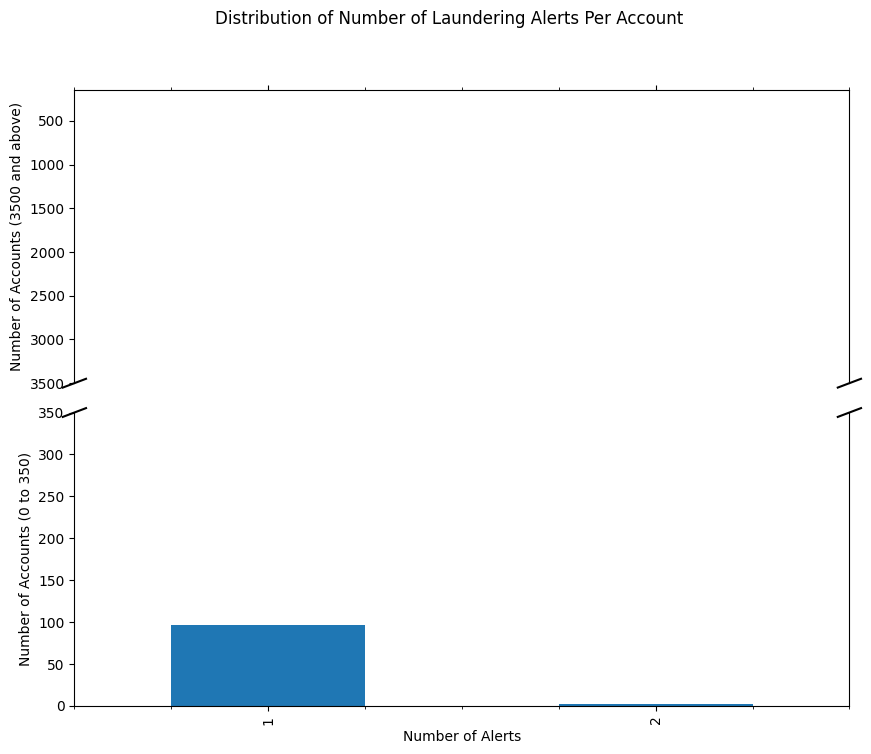

In [37]:
laundering_df = df[df['Is_laundering'] == 1]

account_alert_counts = laundering_df.groupby('Sender_account').size()
alert_distribution = account_alert_counts.value_counts()
alert_distribution = alert_distribution.sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
fig.subplots_adjust(hspace=0.1)

alert_distribution.plot(kind='bar', ax=ax1)
alert_distribution.plot(kind='bar', ax=ax2)

fig.suptitle('Distribution of Number of Laundering Alerts Per Account')

ax1.set_ylim(3500, alert_distribution.max()+50)
ax2.set_ylim(0, 350)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .015  # diagonal lines size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

ax2.set_ylabel('Number of Accounts (0 to 350)')
ax1.set_ylabel('Number of Accounts (3500 and above)')
ax2.set_xlabel('Number of Alerts')

In [38]:
df[['Sender_account', 'Receiver_account']].describe()

,Sender_account,Receiver_account
count,1.000000e+05,1.000000e+05
mean,5.004964e+09,4.994993e+09
std,2.886250e+09,2.884592e+09
min,9.217200e+04,2.793990e+05
25%,2.500961e+09,2.507442e+09
50%,4.995244e+09,4.979547e+09
75%,7.506431e+09,7.482154e+09
max,9.999346e+09,9.999958e+09


In [39]:
df['Is_laundering'].value_counts()

,count
Is_laundering,
0,99900
1,100


# Checking Skewness

Original Skewness: 24.42962605031987
Log-Transformed Skewness: -1.0077407190672134


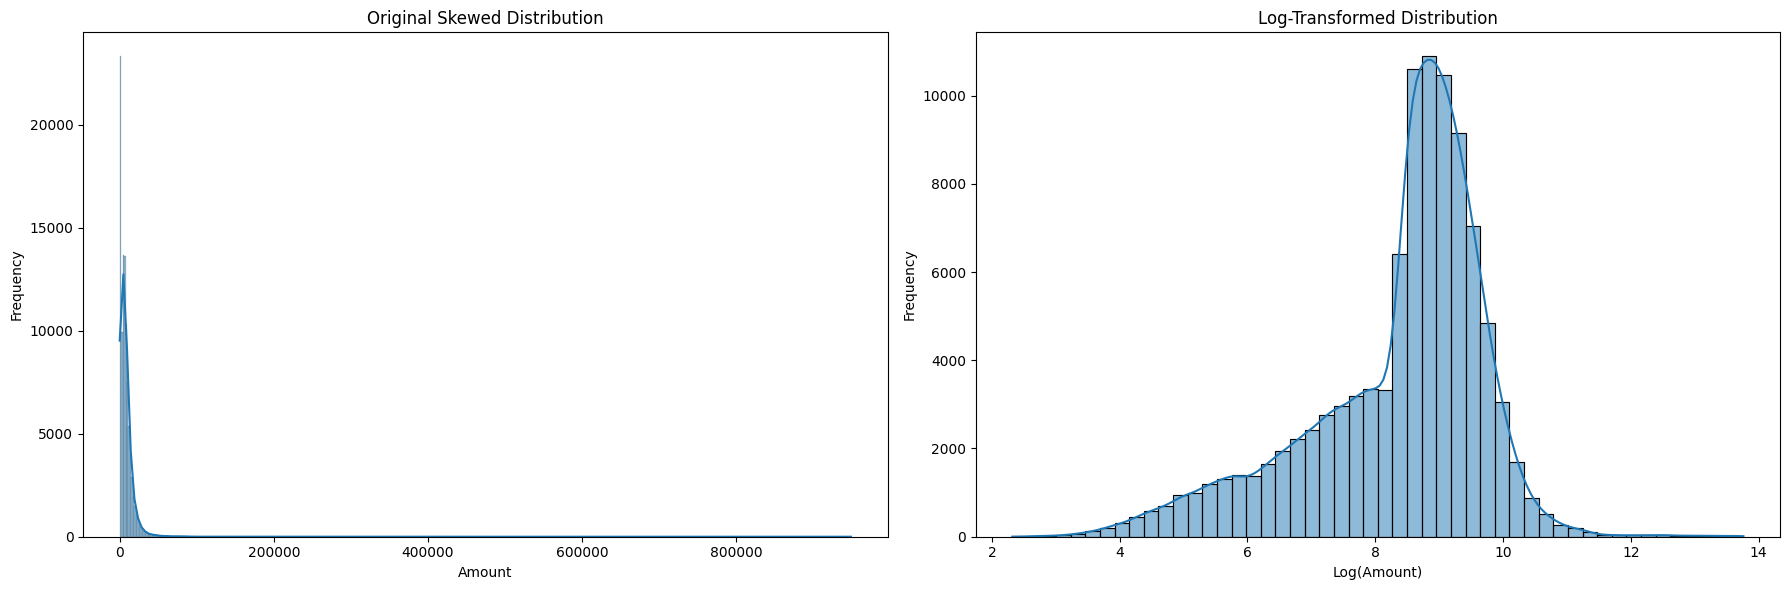

In [42]:
skewed_data = df['Amount']

original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

# Apply a log transformation
log_transformed_data = np.log1p(skewed_data)
# skewness after log transformation
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(skewed_data, bins=500, kde=True, ax=ax[0])
ax[0].set_title('Original Skewed Distribution')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

sns.histplot(log_transformed_data, bins=50, kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Distribution')
ax[1].set_xlabel('Log(Amount)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show();

In [45]:
total_amount_pivot = pd.pivot_table(df, index=["Payment_type"], values='Amount', aggfunc=np.sum)
laundering_count_pivot = df[df['Is_laundering'] == 1].groupby('Payment_type').size().to_frame('Laundering_Count')
normal_count_pivot = df[df['Is_laundering'] == 0].groupby('Payment_type').size().to_frame('Normal_Count')

combined_pivot = total_amount_pivot.join([laundering_count_pivot, normal_count_pivot], how='outer')
combined_pivot = combined_pivot.fillna(0)

cm = sns.light_palette("green", as_cmap=True)
styled_combined_pivot = combined_pivot.style.background_gradient(cmap=cm)

styled_combined_pivot

,Amount,Laundering_Count,Normal_Count
Payment_type,,,
ACH,191280642.174001,14,20982
Cash Deposit,5292875.760000,16,2370
Cash Withdrawal,476488.160000,12,3078
Cheque,191394048.379559,9,21273
Credit card,188435992.010639,17,21154
Cross-border,98300819.645930,23,9838
Debit card,193614664.204063,9,21205


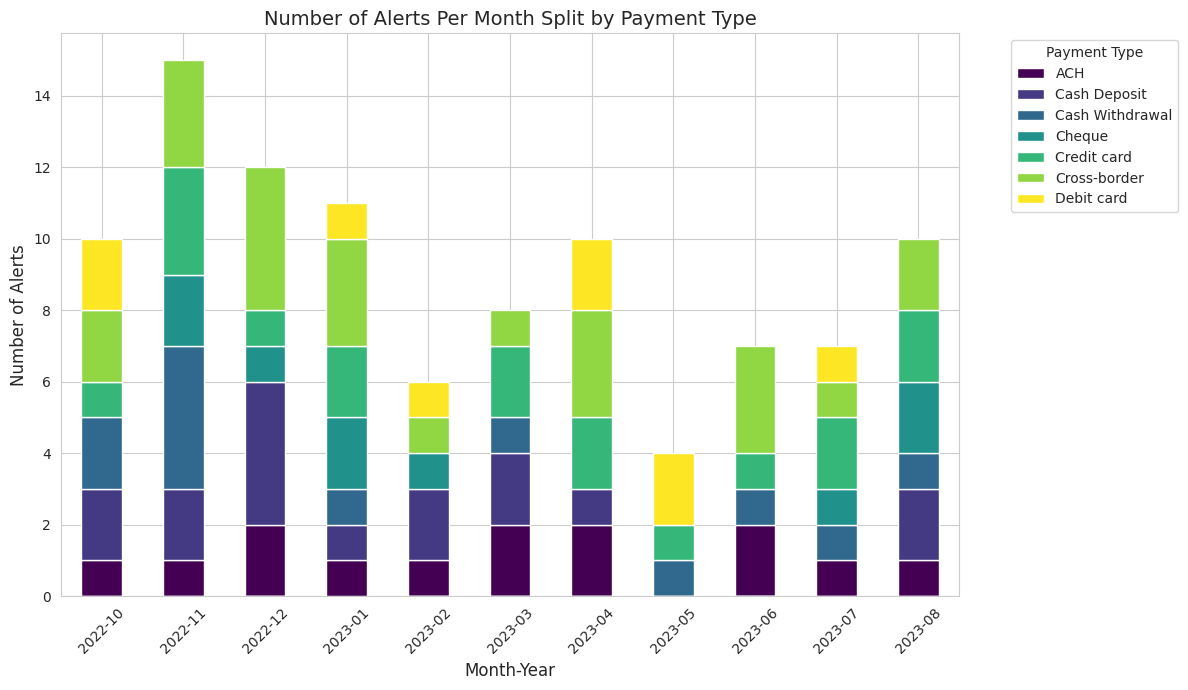

In [46]:
df['Date'] = pd.to_datetime(df['Date'])
grouped_data = df.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()

pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

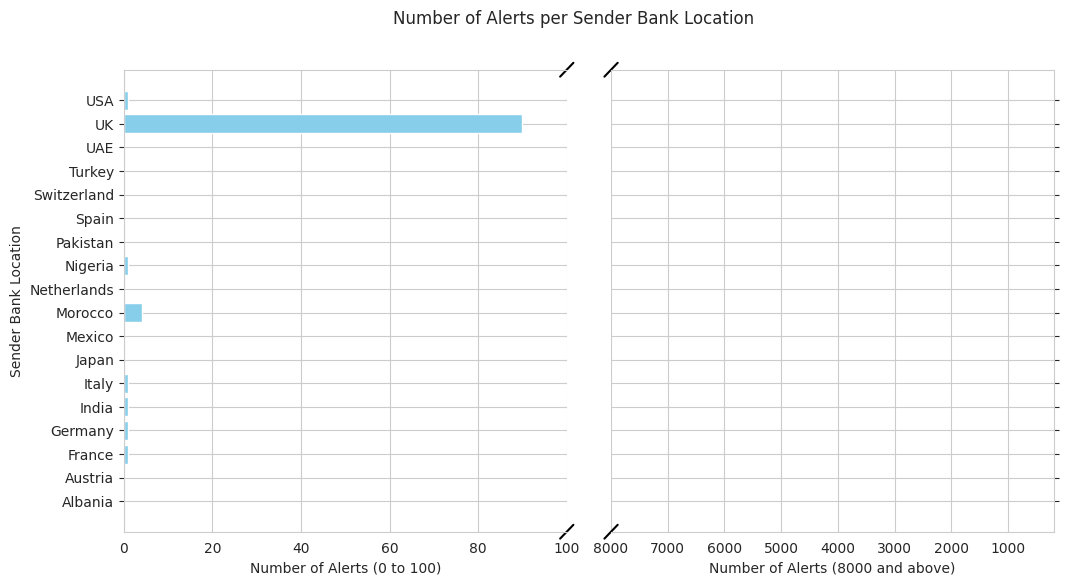

In [47]:
alerts_per_location = df.groupby('Sender_bank_location')['Is_laundering'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.1)

ax1.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')
ax2.barh(alerts_per_location['Sender_bank_location'], alerts_per_location['Is_laundering'], color='skyblue')

ax1.set_xlim(0, 100)  # Set the left subplot values
ax2.set_xlim(8000, max(alerts_per_location['Is_laundering']) + 100)  # Set the right subplot values

fig.suptitle('Number of Alerts per Sender Bank Location')

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.set_yticks([])

d = .015  # Size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

ax1.set_xlabel('Number of Alerts (0 to 100)')
ax2.set_xlabel('Number of Alerts (8000 and above)')
ax1.set_ylabel('Sender Bank Location')

ax1.set_yticks(range(len(alerts_per_location['Sender_bank_location'])))
ax1.set_yticklabels(alerts_per_location['Sender_bank_location'])

plt.show();

In [48]:
df.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'Year', 'Month', 'Day', 'Week'],
      dtype='object')

In [49]:
## Dropping some columns

columns_to_drop = ['Time', 'Date']

df.drop(columns=columns_to_drop, inplace=True)

df.columns

Index(['Sender_account', 'Receiver_account', 'Amount', 'Payment_currency',
       'Received_currency', 'Sender_bank_location', 'Receiver_bank_location',
       'Payment_type', 'Is_laundering', 'Laundering_type', 'Year', 'Month',
       'Day', 'Week'],
      dtype='object')

In [50]:
skewed_data = df['Amount']
original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

log_transformed_data = np.log1p(skewed_data)
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

df['Amount'] = log_transformed_data

Original Skewness: 24.42962605031987
Log-Transformed Skewness: -1.0077407190672134


In [51]:
num_cols = df.select_dtypes(exclude="object").columns
print(f"We have {len(num_cols)} numerical columns: {num_cols.tolist()}")

categorical_cols = df.select_dtypes(include="object").columns
print(f"We have {len(categorical_cols)} categorical columns: {categorical_cols.tolist()}")

We have 8 numerical columns: ['Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'Year', 'Month', 'Day', 'Week']
We have 6 categorical columns: ['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Laundering_type']


In [52]:
## Checking for missing values

df.isnull().sum()

,0
Sender_account,0
Receiver_account,0
Amount,0
Payment_currency,0
Received_currency,0
Sender_bank_location,0
Receiver_bank_location,0
Payment_type,0
Is_laundering,0
Laundering_type,0


In [53]:
## Saving a copy of the dataset

df = df.copy(deep=True)
df.head(2)

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Year,Month,Day,Week
9232719,4248061080,9527052910,9.509091,Mexican Peso,UK pounds,UK,UK,Debit card,0,Normal_Plus_Mutual,2023,8,14,33
7996180,9130896737,908371799,9.257324,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_Out,2023,7,2,26


# Data Preprocessing

In [54]:
df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Year,Month,Day,Week
9232719,4248061080,9527052910,9.509091,Mexican Peso,UK pounds,UK,UK,Debit card,0,Normal_Plus_Mutual,2023,8,14,33
7996180,9130896737,908371799,9.257324,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_Out,2023,7,2,26
8575435,1466348255,8545558838,10.174787,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Fan_Out,2023,7,22,29
614744,2181923623,6234034932,6.104949,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out,2022,10,28,43
4092093,8596132461,3638213339,6.914353,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,2023,2,21,8


In [55]:
df.columns

Index(['Sender_account', 'Receiver_account', 'Amount', 'Payment_currency',
       'Received_currency', 'Sender_bank_location', 'Receiver_bank_location',
       'Payment_type', 'Is_laundering', 'Laundering_type', 'Year', 'Month',
       'Day', 'Week'],
      dtype='object')

In [56]:
numeric_cols = df.select_dtypes(exclude="object").columns

numeric_cols

Index(['Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'Year',
       'Month', 'Day', 'Week'],
      dtype='object')

In [57]:
categorical_cols = df.select_dtypes(include="object").columns

categorical_cols

Index(['Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Laundering_type'],
      dtype='object')

In [58]:
## Unique columns in df

unique_counts = df[categorical_cols].nunique()
print("Unique columns in the DataFrame: \n", unique_counts)

Unique columns in the DataFrame: 
 Payment_currency          13
Received_currency         13
Sender_bank_location      18
Receiver_bank_location    18
Payment_type               7
Laundering_type           27
dtype: int64


In [59]:
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering,Year,Month,Day,Week
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0
mean,5.004964e+09,4.994993e+09,8.349553,0.001000,2022.735340,6.145520,15.650330,24.89633
std,2.886250e+09,2.884592e+09,1.396387,0.031607,0.441154,3.547984,8.621244,15.453681
min,9.217200e+04,2.793990e+05,2.317474,0.000000,2022.000000,1.000000,1.000000,1.0
25%,2.500961e+09,2.507442e+09,7.678824,0.000000,2022.000000,3.000000,8.000000,12.0
50%,4.995244e+09,4.979547e+09,8.714255,0.000000,2023.000000,6.000000,16.000000,23.0
75%,7.506431e+09,7.482154e+09,9.256727,0.000000,2023.000000,10.000000,23.000000,41.0
max,9.999346e+09,9.999958e+09,13.762810,1.000000,2023.000000,12.000000,31.000000,52.0


In [60]:
X = df.drop(columns=["Is_laundering"], axis=1)
y = df["Is_laundering"]

In [61]:
numerical_features = X.select_dtypes(exclude="object").columns

numerical_features

Index(['Sender_account', 'Receiver_account', 'Amount', 'Year', 'Month', 'Day',
       'Week'],
      dtype='object')

In [62]:
categorical_features = X.select_dtypes(include="object").columns

categorical_features

Index(['Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Laundering_type'],
      dtype='object')

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder

## Define the pipeline

num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinalencoder", OrdinalEncoder(),
        "scaler", StandardScaler())
    ]
)

In [64]:
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[
    ("OrdinalEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ("RobustScaler", RobustScaler(), numerical_features)
], remainder="passthrough")

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
## Transform the datasets

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [67]:
print(f"Shape of training data: ", X_train.shape, y_train.shape)
print(f"Shape of testing data: ", X_test.shape, y_test.shape)

Shape of training data:  (80000, 13) (80000,)
Shape of testing data:  (20000, 13) (20000,)


# Baseline Model Creation

In [68]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4,8,16],
    'eta': [0.1,0.2,0.3],
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=2,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred)
print("Test AUC: ", test_auc)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ...............................eta=0.1, max_depth=4; total time=   0.4s
[CV] END ...............................eta=0.1, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.1, max_depth=8; total time=   0.2s
[CV] END ...............................eta=0.1, max_depth=8; total time=   0.3s
[CV] END ..............................eta=0.1, max_depth=16; total time=   0.3s
[CV] END ..............................eta=0.1, max_depth=16; total time=   0.3s
[CV] END ...............................eta=0.2, max_depth=4; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=4; total time=   0.4s
[CV] END ...............................eta=0.2, max_depth=8; total time=   0.2s
[CV] END ...............................eta=0.2, max_depth=8; total time=   0.2s
[CV] END ..............................eta=0.2, max_depth=16; total time=   0.2s
[CV] END ..............................eta=0.2, m

# Evaluation of the Model by ROC AUC Curve

Test Set AUC:  1.0


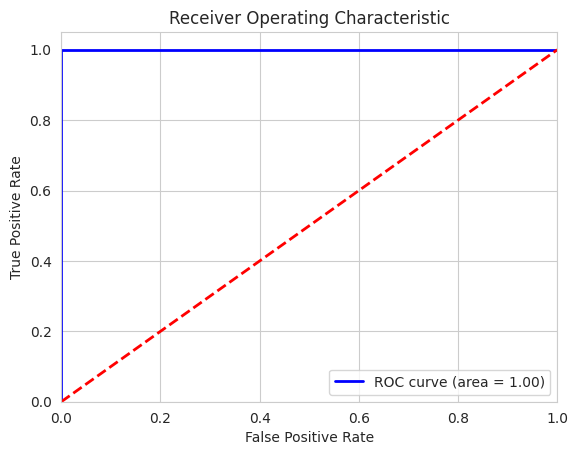

In [71]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

test_probabilities = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probabilities)
print("Test Set AUC: ", test_auc)

fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show();

# Confusion Matrix

In [72]:
from sklearn.metrics import confusion_matrix

Desired TPR of around 90%:


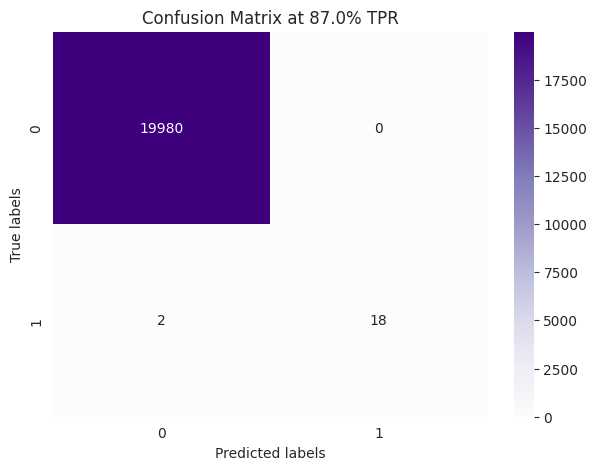

False Positive Rate (FPR): 0.000
True Positive Rate (TPR): 0.900


In [76]:
# Confusion Matrix, TPR, and FPR at around a TPR of 0.87
desired_tpr = 0.87
closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
print(f"Desired TPR of around 90%:")

y_pred = (test_probabilities >= closest_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix at {desired_tpr*100}% TPR')
plt.show()

tn, fp, fn, tp = cm.ravel()
fpr_cm = fp / (fp + tn)
tpr_cm = tp / (tp + fn)

print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

# Classification Report

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19980
           1       1.00      0.90      0.95        20

    accuracy                           1.00     20000
   macro avg       1.00      0.95      0.97     20000
weighted avg       1.00      1.00      1.00     20000



# Handling the Data Imbalance - Upsampling using SMOTE

In [78]:
# upsampling using smote

from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train_os)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(y_train)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", X_train_os.shape, y_train_os.shape)

Class= 0, n=79920 (99.90%)
Class= 1, n=80 (0.10%)
Class= 0, n=79920 (99.90%)
Class= 1, n=79920 (99.90%)
Upsampled data shape:  (159840, 13) (159840,)


In [79]:
from collections import Counter

# Assuming 'y' is your target variable
class_distribution = Counter(y_train_os)

# Print the class distribution
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

# Check if 'y' is balanced
is_balanced = all(count == class_distribution[y_train_os[0]] for count in class_distribution.values())

if is_balanced:
    print("The target variable 'y' is balanced.")
else:
    print("The target variable 'y' is imbalanced.")

Class 0: 79920 samples
Class 1: 79920 samples
The target variable 'y' is balanced.


In [80]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

def fit_classification_models(X, y, test_size=0.2, random_state=42):
    """
    Fit classification models using XGBoost, RandomForest, and ExtraTrees classifiers.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The input data.

    y : array-like of shape (n_samples,)
        The target variable.

    test_size : float, default=0.2
        The proportion of the dataset to include in the test split.

    random_state : int, default=42
        Controls the randomness of the dataset splitting.

    Returns:
    --------
    results : dict
        A dictionary containing the performance metrics for XGBoost, RandomForest, and ExtraTrees classifiers,
        including training and testing results along with confusion matrices and classification reports.
    """

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create pipelines for XGBoost, RandomForest, and ExtraTrees classifiers
    pipelines = {
        'XGBoost': Pipeline([('scaler', RobustScaler()), ('classifier', XGBClassifier())]),
        'Random Forest': Pipeline([('scaler', RobustScaler()), ('classifier', RandomForestClassifier())]),
        'ExtraTreesClassifier': Pipeline([('scaler', RobustScaler()), ('classifier', ExtraTreesClassifier())]),
    }

    # Fit and evaluate XGBoost, RandomForest, and ExtraTrees classifiers
    results = {}

    for classifier_name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)

        # Training results
        y_train_pred = pipeline.predict(X_train)
        train_precision = round(precision_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_recall = round(recall_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_f1 = round(f1_score(y_train, y_train_pred, average="weighted") * 100, 1)
        train_conf_matrix = confusion_matrix(y_train, y_train_pred)
        train_classification_report = classification_report(y_train, y_train_pred, output_dict=True)

        # Testing results
        y_test_pred = pipeline.predict(X_test)
        test_precision = round(precision_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_recall = round(recall_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_f1 = round(f1_score(y_test, y_test_pred, average="weighted") * 100, 1)
        test_conf_matrix = confusion_matrix(y_test, y_test_pred)
        test_classification_report = classification_report(y_test, y_test_pred, output_dict=True)

        results[classifier_name] = {
            'training': {
                'precision': train_precision,
                'recall': train_recall,
                'f1-score': train_f1,
                'confusion_matrix': train_conf_matrix,
                'classification_report': train_classification_report
            },

            'testing': {
                'precision': test_precision,
                'recall': test_recall,
                'f1-score': test_f1,
                'confusion_matrix': test_conf_matrix,
                'classification_report': test_classification_report
            }
        }

    return results

Algorithm: XGBoost
      Metric  Training  Testing
0  Precision     100.0    100.0
1     Recall     100.0    100.0
2   F1-score     100.0    100.0




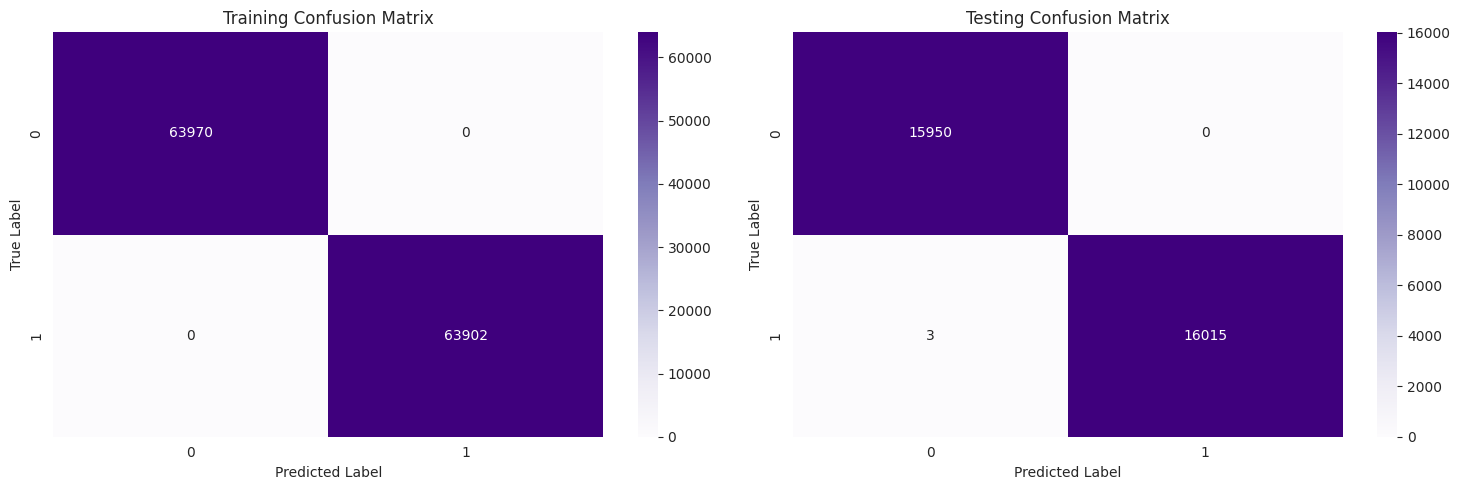

Algorithm: Random Forest
      Metric  Training  Testing
0  Precision     100.0    100.0
1     Recall     100.0    100.0
2   F1-score     100.0    100.0




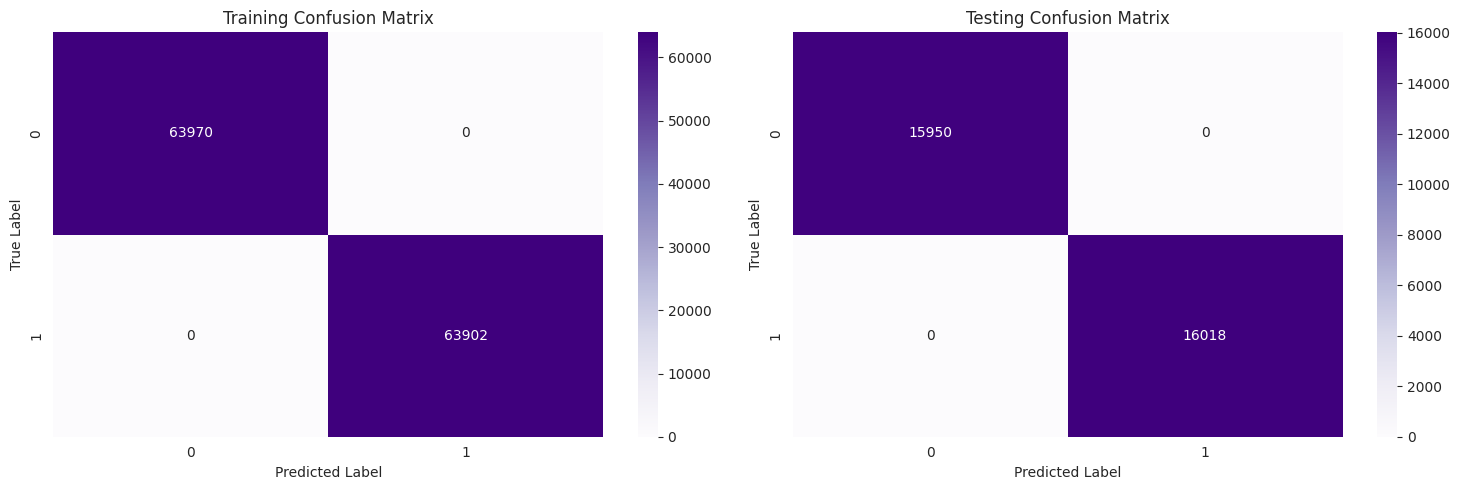

Algorithm: ExtraTreesClassifier
      Metric  Training  Testing
0  Precision     100.0    100.0
1     Recall     100.0    100.0
2   F1-score     100.0    100.0




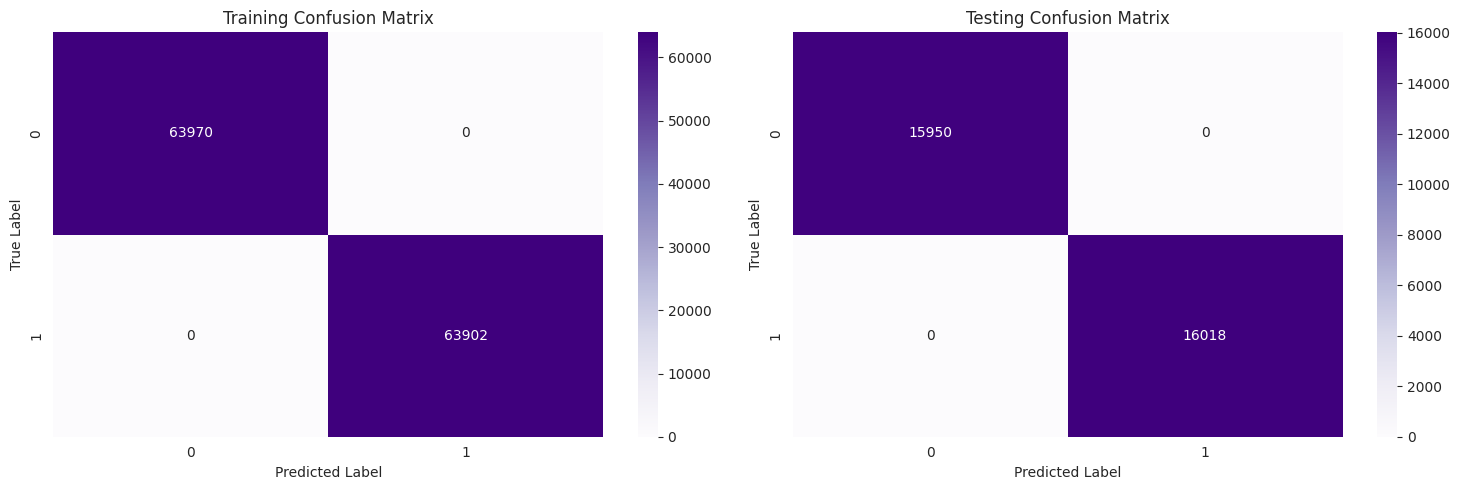

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Call fit_classification_models() function to generate results
results = fit_classification_models(X_train_os, y_train_os)

# Plot confusion matrices and display DataFrame for each algorithm
for classifier_name, metrics in results.items():
    print(f"Algorithm: {classifier_name}")

    # Display DataFrame
    df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-score'],
        'Training': [metrics['training']['precision'], metrics['training']['recall'], metrics['training']['f1-score']],
        'Testing': [metrics['testing']['precision'], metrics['testing']['recall'], metrics['testing']['f1-score']]
    })
    print(df)
    print("\n")

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Training confusion matrix
    sns.heatmap(metrics['training']['confusion_matrix'], annot=True, fmt='d', cmap='Purples', ax=axes[0])
    axes[0].set_title('Training Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Testing confusion matrix
    sns.heatmap(metrics['testing']['confusion_matrix'], annot=True, fmt='d', cmap='Purples', ax=axes[1])
    axes[1].set_title('Testing Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [83]:
# Initialize a list to store the scores
all_scores = []

# Iterate over the results
for classifier_name, metrics in results.items():
    # Append the scores to the list
    all_scores.append({
        'Algorithm': classifier_name,
        'Training Precision': metrics['training']['precision'],
        'Testing Precision': metrics['testing']['precision'],
        'Training Recall': metrics['training']['recall'],
        'Testing Recall': metrics['testing']['recall'],
        'Training F1-score': metrics['training']['f1-score'],
        'Testing F1-score': metrics['testing']['f1-score']
    })

# Create a DataFrame from the scores list
scores_df = pd.DataFrame(all_scores)

# Sort the DataFrame by the 'Testing F1-score' column in descending order
scores_sorted = scores_df.sort_values(by='Testing F1-score', ascending=False)

# Display the sorted DataFrame
scores_sorted

,Algorithm,Training Precision,Testing Precision,Training Recall,Testing Recall,Training F1-score,Testing F1-score
0,XGBoost,100.0,100.0,100.0,100.0,100.0,100.0
1,Random Forest,100.0,100.0,100.0,100.0,100.0,100.0
2,ExtraTreesClassifier,100.0,100.0,100.0,100.0,100.0,100.0
